# Model Analysis
File to test and tune models

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import json

## Pre-requisites 
Loading data and declaring functions for visualising model perfrmance 

In [43]:
# Data Loading
def load_pca_data(split_dir):
    X = np.load(os.path.join(split_dir, 'X_pca.npy'))
    y = np.load(os.path.join(split_dir, 'y.npy'))
    return X, y

def load_config(config_path):
    """
    Load config parameters (data paths, etc.) from JSON file.
    Args:
        config_path (str): Where to read config file.
    Returns:
        config (dict): Dictionary of config parameters.
    """
    with open(config_path, "r") as f:
        config = json.load(f)
    return config

In [45]:
config = load_config("../config.json")
data_root = config["pca_output_dir"]
train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'val')
test_dir = os.path.join(data_root, 'test')
X_train, y_train = load_pca_data(train_dir)
X_val, y_val = load_pca_data(val_dir)
X_test, y_test = load_pca_data(test_dir)

In [46]:
def evaluate_model(clf, X, y, set_name="Validation"):
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)[:, 1] if len(clf.classes_) == 2 else clf.predict_proba(X)
    acc = accuracy_score(y, y_pred)
    print(f"{set_name} Accuracy: {acc:.3f}")
    print(f"{set_name} Classification Report:\n", classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{set_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return y_pred, y_prob

In [47]:
def plot_roc_curve(y, y_prob, set_name="Validation"):
    if len(np.unique(y)) == 2:
        fpr, tpr, thresholds = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{set_name} ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
        print(f"{set_name} ROC AUC: {roc_auc:.3f}")

In [50]:
def plot_precision_recall(y_true, y_scores, class_names=None):
    """
    Plots precision-recall curves for each class.
    Args:
        y_true (array-like): True labels (N,)
        y_scores (array-like): Shape (N, n_classes) predicted probabilities
        class_names (list): List of class names for legend
    """
    n_classes = y_scores.shape[1]
    plt.figure()
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve((y_true == i).astype(int), y_scores[:, i])
        ap = average_precision_score((y_true == i).astype(int), y_scores[:, i])
        label = f"Class {i}" if class_names is None else class_names[i]
        plt.plot(recall, precision, lw=2, label=f'{label} (AP={ap:.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall curve")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Logistic Regression

In [7]:
def train_logistic_regression(X_train, y_train):
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    return clf

Validation Results:
Validation Accuracy: 0.848
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.80      0.80        66
           1       0.77      0.77      0.77        66
           2       0.98      0.97      0.98        65

    accuracy                           0.85       197
   macro avg       0.85      0.85      0.85       197
weighted avg       0.85      0.85      0.85       197



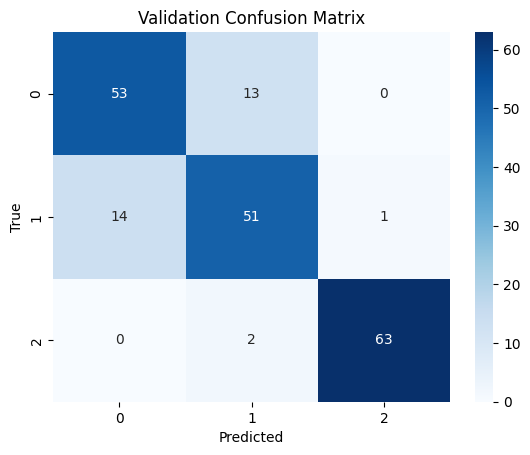

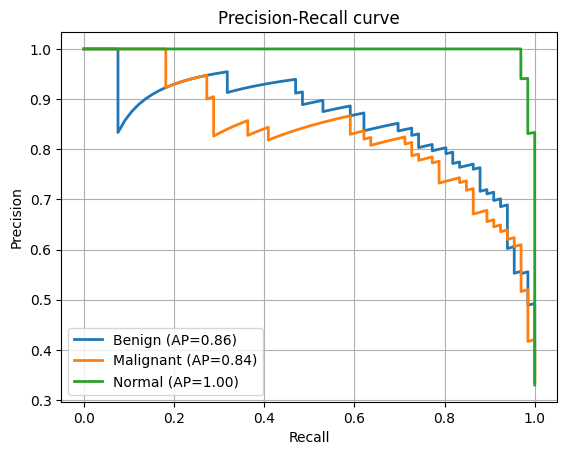

Test Results:
Test Accuracy: 0.883
Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.77      0.82        65
           1       0.79      0.88      0.83        66
           2       0.99      1.00      0.99        66

    accuracy                           0.88       197
   macro avg       0.89      0.88      0.88       197
weighted avg       0.89      0.88      0.88       197



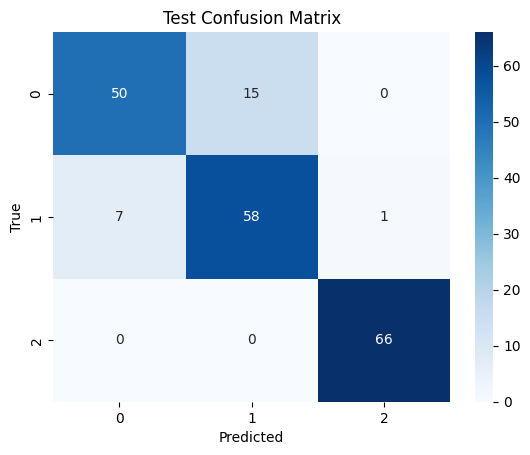

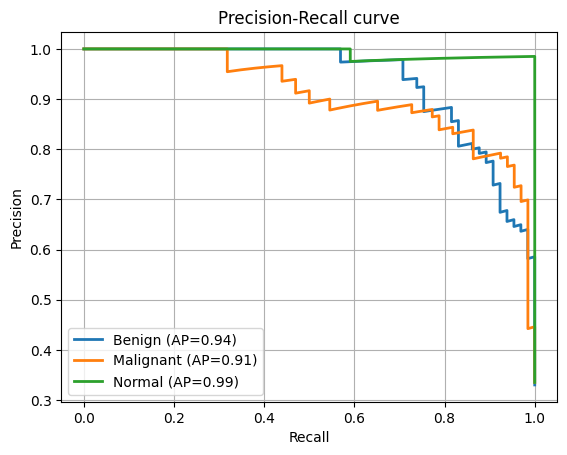

In [52]:

class_names = ["Benign", "Malignant", "Normal"]
clf = train_logistic_regression(X_train, y_train)

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(clf, X_val, y_val, "Validation")
plot_roc_curve(y_val, y_val_prob, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names)

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(clf, X_test, y_test, "Test")
plot_roc_curve(y_test, y_test_prob, "Test")
plot_precision_recall(y_test, y_test_prob, class_names)


# k Nearest Neighbour

In [53]:
def train_knn_weighted(X_train, y_train, k=5):
    # Use weights="distance" so nearer neighbors count more
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    return knn

k=1, Cross-Validation Error: 0.1134
k=2, Cross-Validation Error: 0.1429
k=3, Cross-Validation Error: 0.1418
k=4, Cross-Validation Error: 0.1472
k=5, Cross-Validation Error: 0.1570
k=6, Cross-Validation Error: 0.1451
k=7, Cross-Validation Error: 0.1636
k=8, Cross-Validation Error: 0.1559
k=9, Cross-Validation Error: 0.1712
k=10, Cross-Validation Error: 0.1581
k=11, Cross-Validation Error: 0.1701
k=12, Cross-Validation Error: 0.1690
k=13, Cross-Validation Error: 0.1875
k=14, Cross-Validation Error: 0.1712
k=15, Cross-Validation Error: 0.1799
k=16, Cross-Validation Error: 0.1875
k=17, Cross-Validation Error: 0.1908
k=18, Cross-Validation Error: 0.1865
k=19, Cross-Validation Error: 0.1963
k=20, Cross-Validation Error: 0.1919
Best k found: 1 with error 0.1134


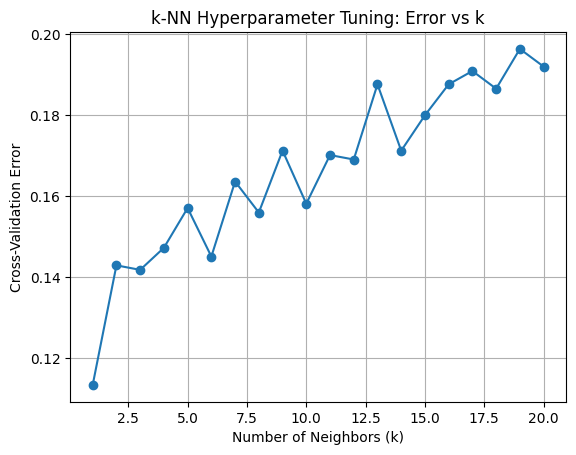

In [54]:
def knn_cross_validation(X_train, y_train, k_range=range(1, 21), cv=5):
    """
    Performs k-fold cross-validation to find the best k in k-NN
    Args:
        X_train (ndarray): Training features
        y_train (ndarray): Training labels
        k_range (iterable): Values of k to evaluate
        cv (int): Number of cross-validation folds
    Returns:
        best_k (int): Value of k with lowest error
        validation_errors (list): Average error for each k
    """
    validation_errors = []

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        # Use cross_val_score with accuracy scoring
        scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring='accuracy')
        avg_error = 1 - scores.mean()  # error = 1 - accuracy
        validation_errors.append(avg_error)
        print(f"k={k}, Cross-Validation Error: {avg_error:.4f}")

    best_k = k_range[np.argmin(validation_errors)]
    print(f"Best k found: {best_k} with error {min(validation_errors):.4f}")

    # Plot error curve
    plt.figure()
    plt.plot(k_range, validation_errors, marker='o')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Cross-Validation Error')
    plt.title('k-NN Hyperparameter Tuning: Error vs k')
    plt.grid(True)
    plt.show()

    return best_k, validation_errors


best_k, errors = knn_cross_validation(X_train, y_train, k_range=range(1,21), cv=5)


Validation Results:
Validation Accuracy: 0.873
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83        66
           1       0.79      0.85      0.82        66
           2       1.00      0.95      0.98        65

    accuracy                           0.87       197
   macro avg       0.88      0.87      0.87       197
weighted avg       0.88      0.87      0.87       197



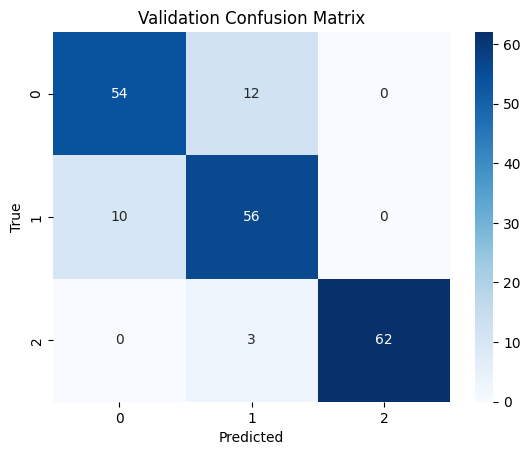

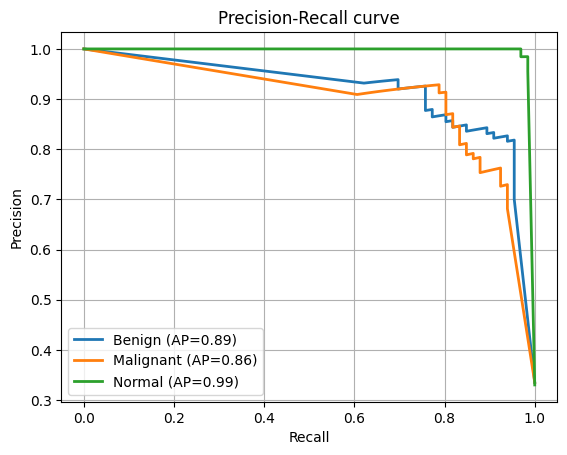

Test Results:
Test Accuracy: 0.893
Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.75      0.84        65
           1       0.79      0.95      0.86        66
           2       0.97      0.97      0.97        66

    accuracy                           0.89       197
   macro avg       0.91      0.89      0.89       197
weighted avg       0.91      0.89      0.89       197



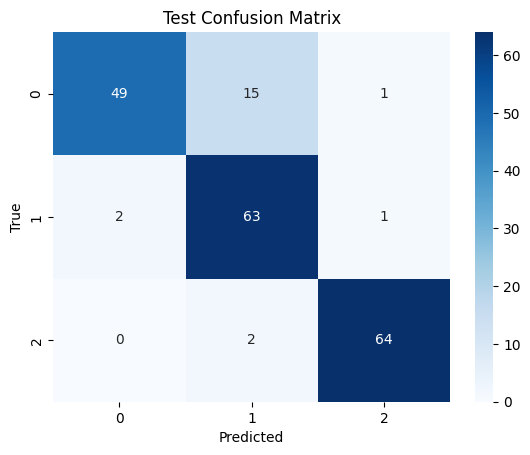

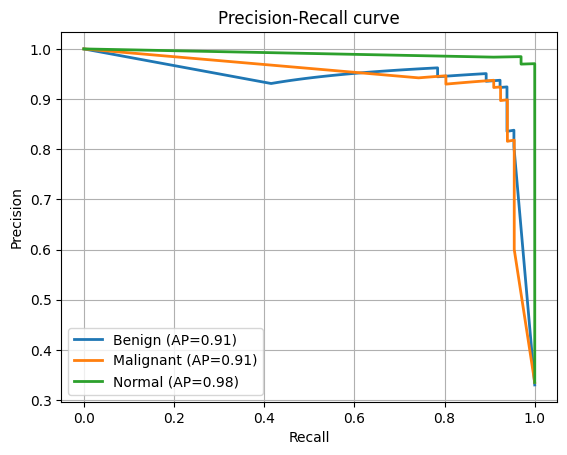

In [57]:
#Initilsie k
k = 3

knn_clf = train_knn_weighted(X_train, y_train, k=k)

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(knn_clf, X_val, y_val, "Validation")
plot_roc_curve(y_val, y_val_prob, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names)

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(knn_clf, X_test, y_test, "Test")
plot_roc_curve(y_test, y_test_prob, "Test")
plot_precision_recall(y_test, y_test_prob, class_names)

# Support Vector Mechanism

In [22]:
def train_svm(X_train, y_train, kernel='rbf', C=1.0, gamma='scale'):
    """
    Trains SVM with specified kernel and hyperparameters.
    multiclass is handled by one-vs-one automatically by scikit-learn's SVC.
    """
    svm = SVC(kernel=kernel, C=C, gamma=gamma, probability=True, class_weight='balanced', random_state=42)
    svm.fit(X_train, y_train)
    return svm

Validation Results:
Validation Accuracy: 0.878
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84        66
           1       0.84      0.80      0.82        66
           2       0.97      0.98      0.98        65

    accuracy                           0.88       197
   macro avg       0.88      0.88      0.88       197
weighted avg       0.88      0.88      0.88       197



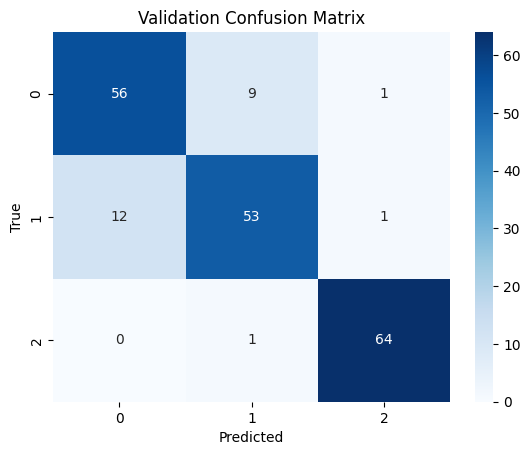

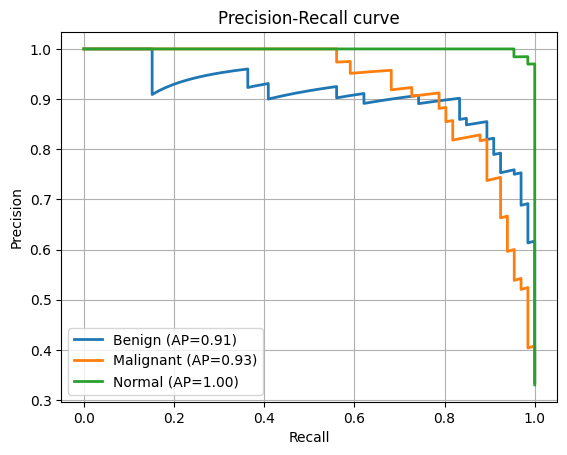

Test Results:
Test Accuracy: 0.914
Test Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.89        65
           1       0.85      0.92      0.88        66
           2       0.96      0.98      0.97        66

    accuracy                           0.91       197
   macro avg       0.92      0.91      0.91       197
weighted avg       0.92      0.91      0.91       197



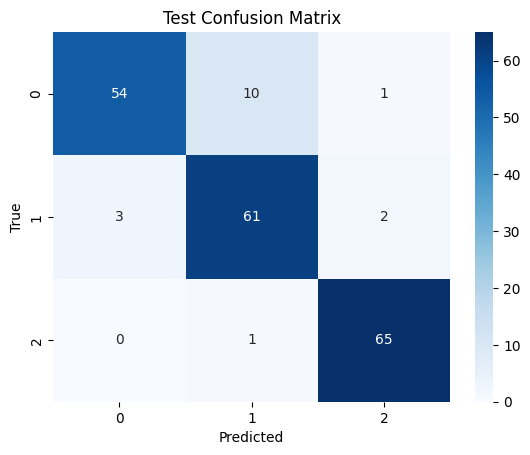

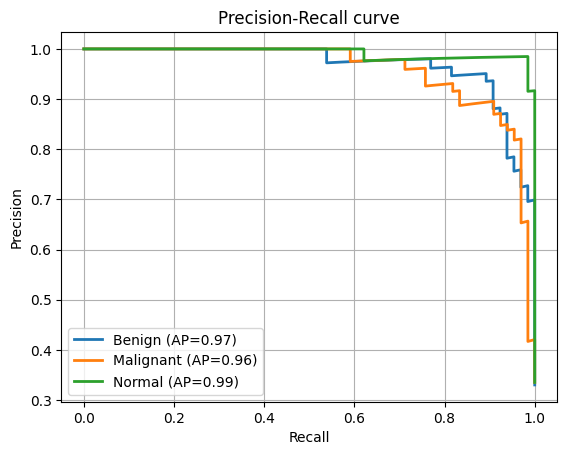

In [58]:
svm_clf = train_svm(X_train, y_train, kernel='rbf', C=1, gamma='scale')

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(svm_clf, X_val, y_val, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names=["Benign", "Malignant", "Normal"])

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(svm_clf, X_test, y_test, "Test")
plot_precision_recall(y_test, y_test_prob, class_names=["Benign", "Malignant", "Normal"])
